
0: 640x480 1 malaysia-car-plate-number, 126.9ms
Speed: 15.2ms preprocess, 126.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


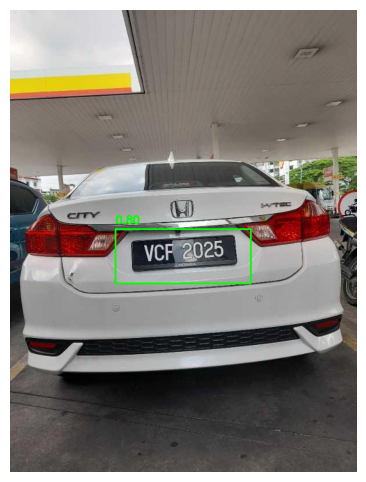

In [3]:
from ultralytics import YOLO
import cv2, torch
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = YOLO('runs/detect/roboflowtrain1/weights/best.pt').to(device)

def detect_plate(image, conf_thresh=0.5):
    results = model(image, device=device, conf=conf_thresh)
    boxes = []
    for r in results:
        for b in r.boxes:
            x1, y1, x2, y2 = map(int, b.xyxy[0])
            conf = float(b.conf[0])
            boxes.append((x1, y1, x2, y2, conf))
    return boxes

def show_plate(image, boxes):
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for (x1, y1, x2, y2, conf) in boxes:
        cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(img_rgb, f'{conf:.2f}', (x1, max(y1-10,20)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

    plt.figure(figsize=(10,6))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

# Run
img = cv2.imread('testimg.jpg')
detections = detect_plate(img)
show_plate(img, detections)

In [ ]:
def detect_vehicle():
    pass


In [ ]:
def secondary_verification():
    pass


0: 640x480 1 malaysia-car-plate-number, 135.6ms
Speed: 16.8ms preprocess, 135.6ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 480)


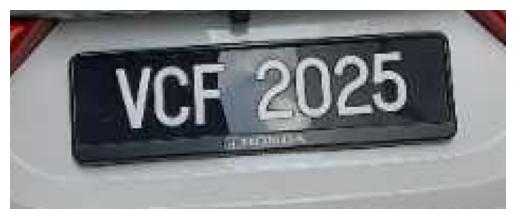

In [4]:
def crop_plate(image, coordinates, save=False, prefix="plate"):
    """
    Crop license plate regions from the image based on YOLO coordinates.
    
    Args:
        image (numpy.ndarray): Original input image.
        coordinates (list): list of (x1, y1, x2, y2, conf)
        save (bool): if True, save cropped plates as image files.
        prefix (str): filename prefix for saved crops.
    
    Returns:
        list of cropped plate images.
    """
    crops = []
    for i, (x1, y1, x2, y2, conf) in enumerate(coordinates):
        # Clamp coordinates to image boundaries
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(image.shape[1]-1, x2), min(image.shape[0]-1, y2)
        
        plate_crop = image[y1:y2, x1:x2].copy()
        crops.append(plate_crop)
        
        if save:
            filename = f"{prefix}_{i}_{conf:.2f}.jpg"
            cv2.imwrite(filename, plate_crop)
    
    return crops

img = cv2.imread("testimg.jpg")
detections = detect_plate(img)
crops = crop_plate(img, detections, save=True)

# Display first crop inline
import matplotlib.pyplot as plt
if crops:
    plt.imshow(cv2.cvtColor(crops[0], cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [ ]:
def enhance_image():
    pass

In [ ]:
import easyocr

# Initialize once (loading the model is heavy)
reader = easyocr.Reader(['en'], gpu=True)  

def perform_ocr(plate_images, conf_thresh=0.5):
    """
    Perform OCR on cropped license plate images using EasyOCR.
    
    Args:
        plate_images (list): list of cropped plate images (numpy arrays)
        conf_thresh (float): minimum confidence to accept result

    Returns:
        list of tuples (text, confidence)
    """
    results = []
    for i, img in enumerate(plate_images):
        ocr_out = reader.readtext(img)
        if not ocr_out:
            results.append(("", 0.0))
            continue
        
        # Pick the highest-confidence detection
        text, conf = max(((t, c) for (_, t, c) in ocr_out), key=lambda x: x[1])
        
        if conf >= conf_thresh:
            results.append((text.strip(), conf))
        else:
            results.append(("", conf))
    return results

img = cv2.imread("testimg.jpg")
detections = detect_plate(img)
crops = crop_plate(img, detections)

ocr_results = perform_ocr(crops)

for i, (text, conf) in enumerate(ocr_results):
    print(f"Plate {i}: {text} (conf={conf:.2f})")

Progress: |██████████████████████████████████████████████████| 100.0% Complete
0: 640x480 1 malaysia-car-plate-number, 108.6ms
Speed: 9.0ms preprocess, 108.6ms inference, 33.0ms postprocess per image at shape (1, 3, 640, 480)
Plate 0: VCF 2025 (conf=0.92)



0: 640x480 1 malaysia-car-plate-number, 87.0ms
Speed: 17.3ms preprocess, 87.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 480)


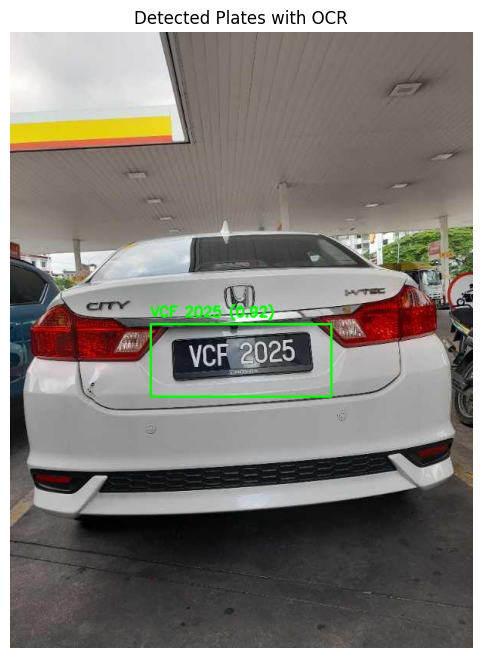

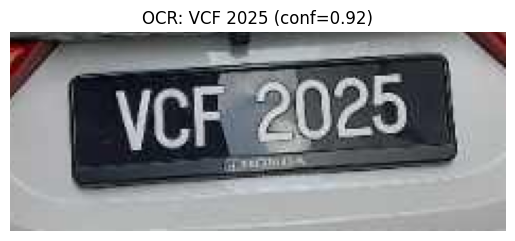

In [7]:
def perform_ocr(plate_images, conf_thresh=0.5):
    results = []
    for img in plate_images:
        ocr_out = reader.readtext(img)
        if not ocr_out:
            results.append(("", 0.0))
            continue
        text, conf = max(((t, c) for (_, t, c) in ocr_out), key=lambda x: x[1])
        if conf >= conf_thresh:
            results.append((text.strip(), conf))
        else:
            results.append(("", conf))
    return results

def show_results(image, boxes, ocr_results):
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for (bbox, ocr) in zip(boxes, ocr_results):
        x1, y1, x2, y2, conf_det = bbox
        text, conf_ocr = ocr
        label = f"{text} ({conf_ocr:.2f})" if text else f"conf {conf_det:.2f}"
        cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(img_rgb, label, (x1, max(y1-10, 20)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)
    plt.figure(figsize=(12,8))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title("Detected Plates with OCR")
    plt.show()

# ---- Run on an example ----
img = cv2.imread('testimg.jpg')
boxes = detect_plate(img)
crops = crop_plate(img, boxes)
ocr_results = perform_ocr(crops)
show_results(img, boxes, ocr_results)

# Show cropped plates individually
for i, (crop, (text, conf)) in enumerate(zip(crops, ocr_results)):
    plt.figure()
    plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
    plt.title(f"OCR: {text} (conf={conf:.2f})")
    plt.axis('off')
    plt.show()